In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, cross_val_score

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')
from joblib import dump #Save

import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
%config InlineBackend.figure_format = 'retina'

---
## 인코딩 별 데이터

In [93]:
# data_int = pd.read_csv('../dataset/app_int.csv') # Integer Encoding
# data_bin = pd.read_csv('../dataset/app_bin.csv') # Binary Encoding
data_dum = pd.read_csv('../dataset/app_dum.csv') # One Hot Encoding

In [94]:
data_cat = pd.read_excel('../dataset/appstore.xlsx')
data_cat

,Unnamed: 0,Category,Available_Age,Size,Price,Free,Rating,Reviews
0,1,Book,1,13,0,True,5.00,1
1,10,Book,4,25,0,True,4.78,1285
2,11,Book,4,60,0,True,4.79,1839
3,12,Lifestyle,1,3,2,False,4.67,242
4,13,Book,4,2,1,False,3.10,21
...,...,...,...,...,...,...,...,...
546051,1230360,Utilities,1,39,0,True,5.00,1
546052,1230368,Utilities,1,92,0,True,4.43,7
546053,1230371,Utilities,1,16,0,True,3.92,143
546054,1230372,Utilities,1,37,0,True,4.83,1500


In [95]:
# data_int.info()

In [96]:
# data_bin.info()

In [97]:
data_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546056 entries, 0 to 546055
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       546056 non-null  int64  
 1   Available_Age                    546056 non-null  int64  
 2   Size                             546056 non-null  int64  
 3   Price                            546056 non-null  int64  
 4   Free                             546056 non-null  bool   
 5   Rating                           546056 non-null  float64
 6   Reviews                          546056 non-null  int64  
 7   Category_Book                    546056 non-null  bool   
 8   Category_Business                546056 non-null  bool   
 9   Category_Developer Tools         546056 non-null  bool   
 10  Category_Education               546056 non-null  bool   
 11  Category_Entertainment           546056 non-null  bool   
 12  Ca

### 데이터 살펴보기

- Reviews가 rating count로 이어지는지 확인 > X (평점을 주고 리뷰를 쓰지 않을 수 있음.)
- 평점은 1 to 5 까지 줄 수 있음.

- 각 데이터 분포 시각화(데이터 구간별 정리 고려)

In [98]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546056 entries, 0 to 546055
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     546056 non-null  int64  
 1   Category       546056 non-null  object 
 2   Available_Age  546056 non-null  int64  
 3   Size           546056 non-null  int64  
 4   Price          546056 non-null  int64  
 5   Free           546056 non-null  bool   
 6   Rating         546056 non-null  float64
 7   Reviews        546056 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 29.7+ MB


In [99]:
# data_int.columns

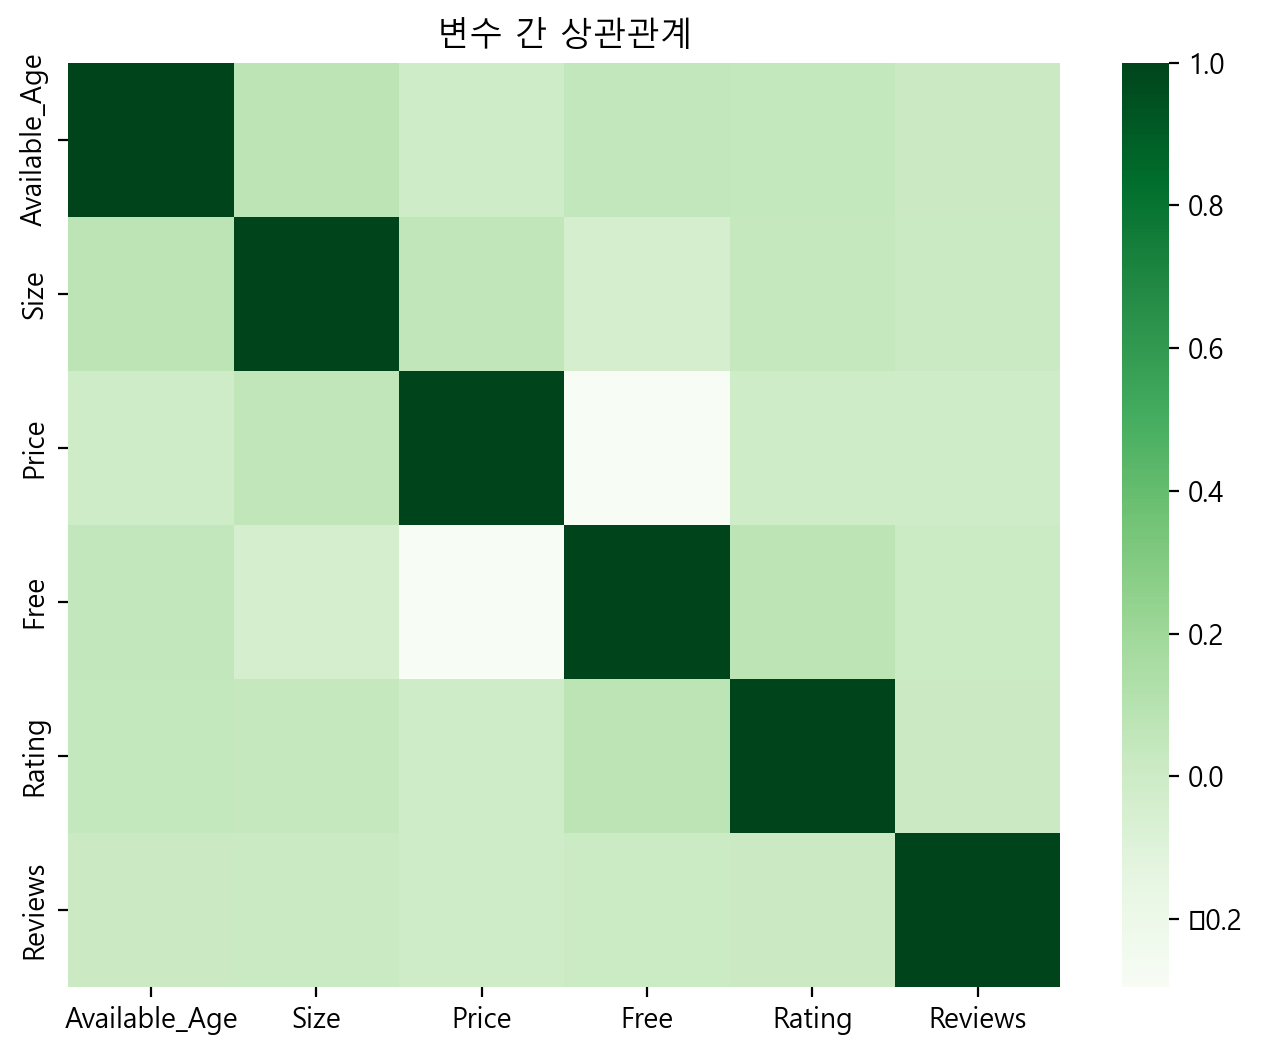

In [100]:
plt.figure(figsize=(8,6))
sns.heatmap(data_cat.drop(['Category', 'Unnamed: 0'], axis=1).corr(), cmap='Greens')
plt.title('변수 간 상관관계')
plt.show()

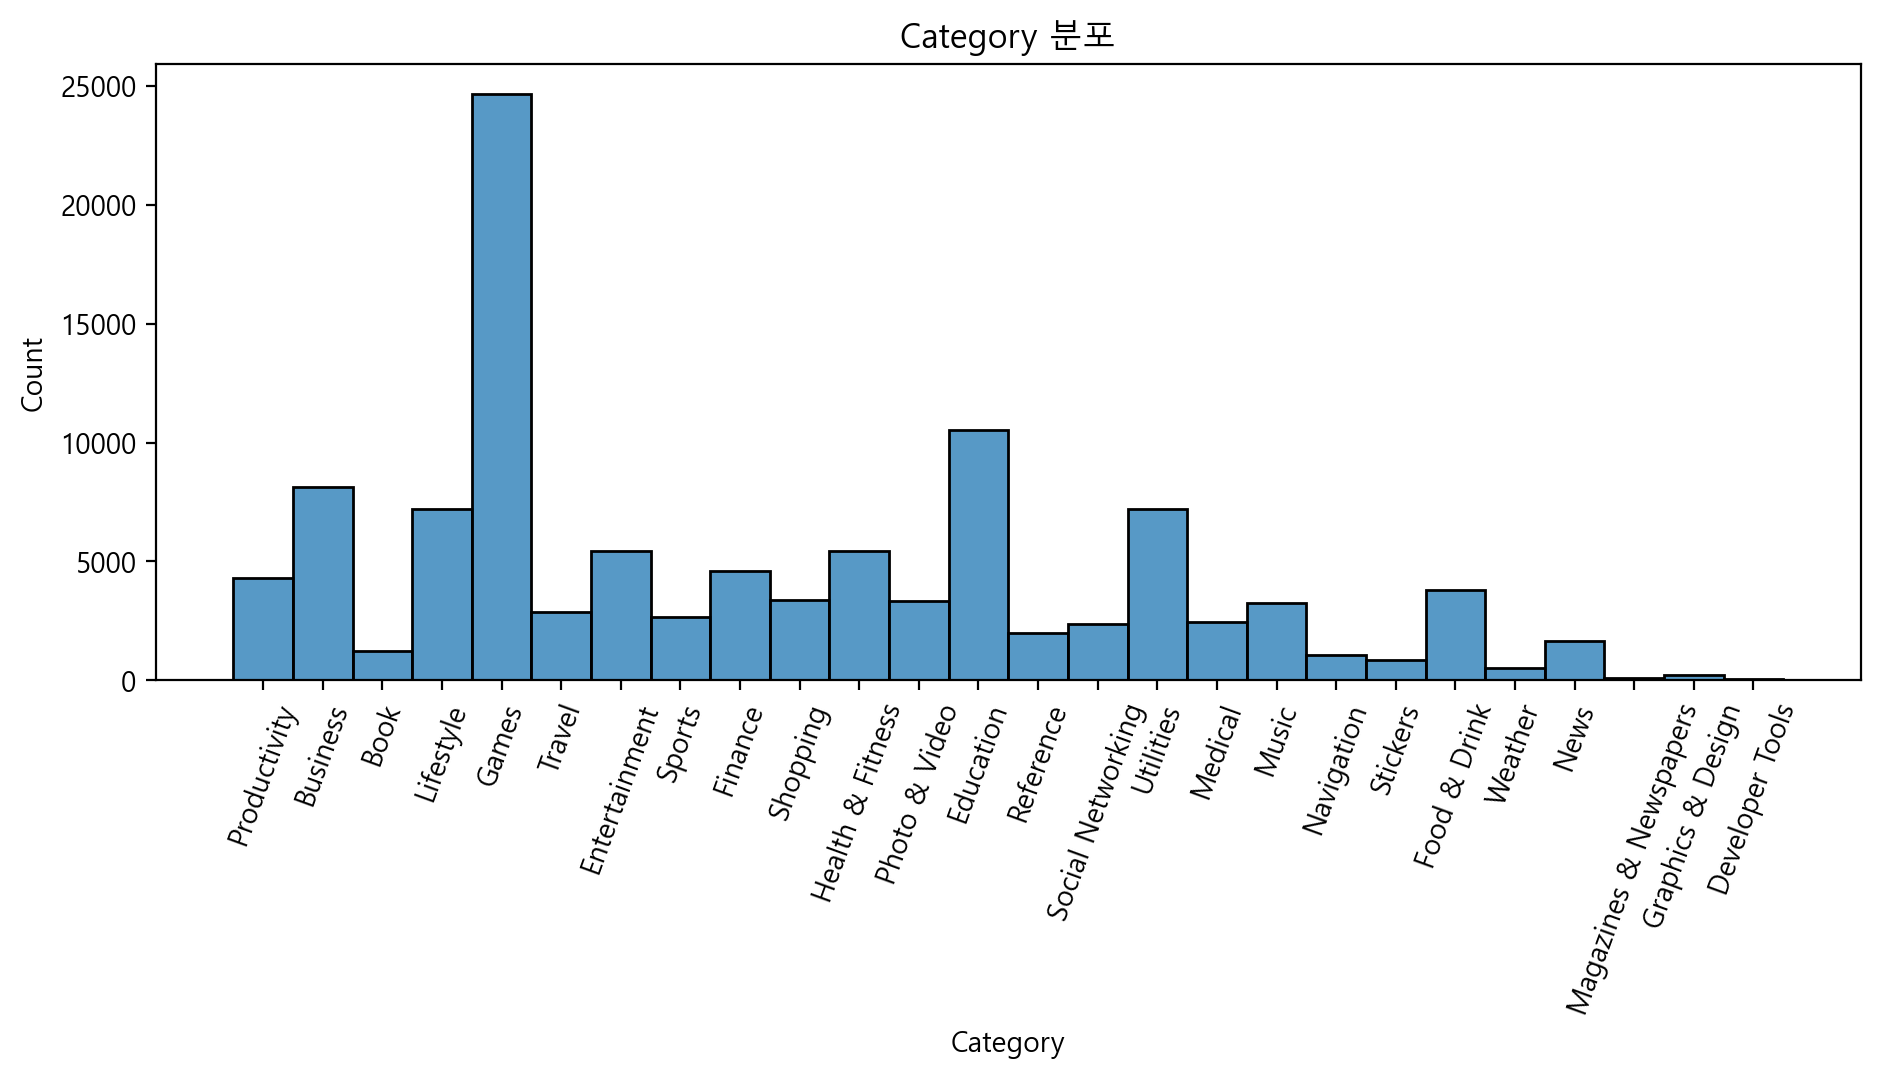

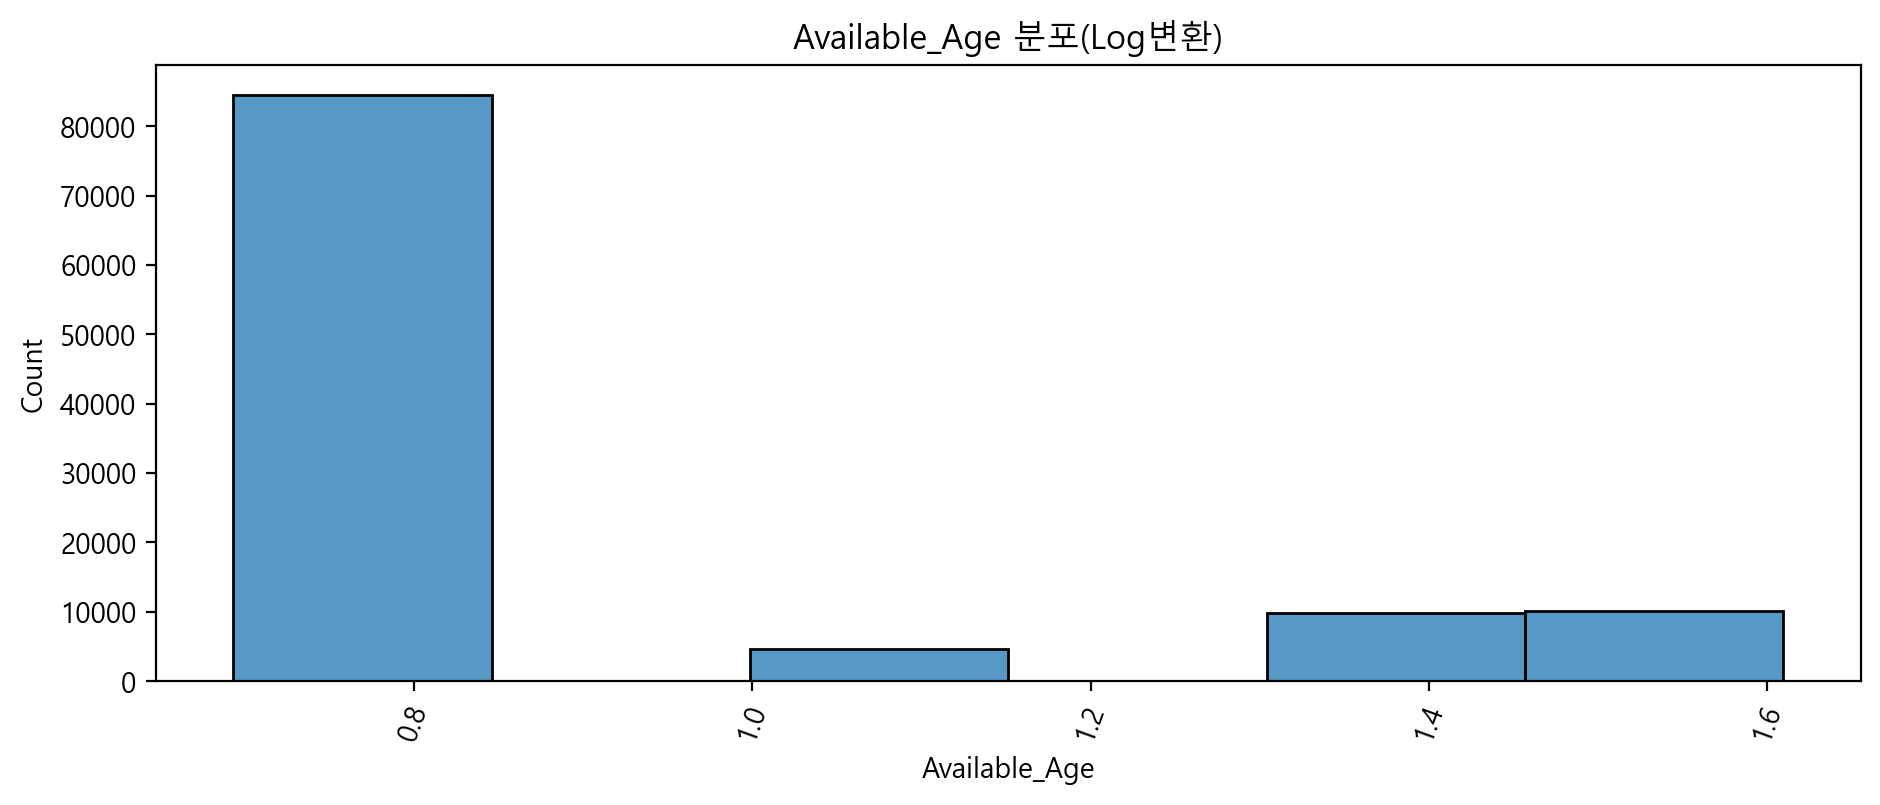

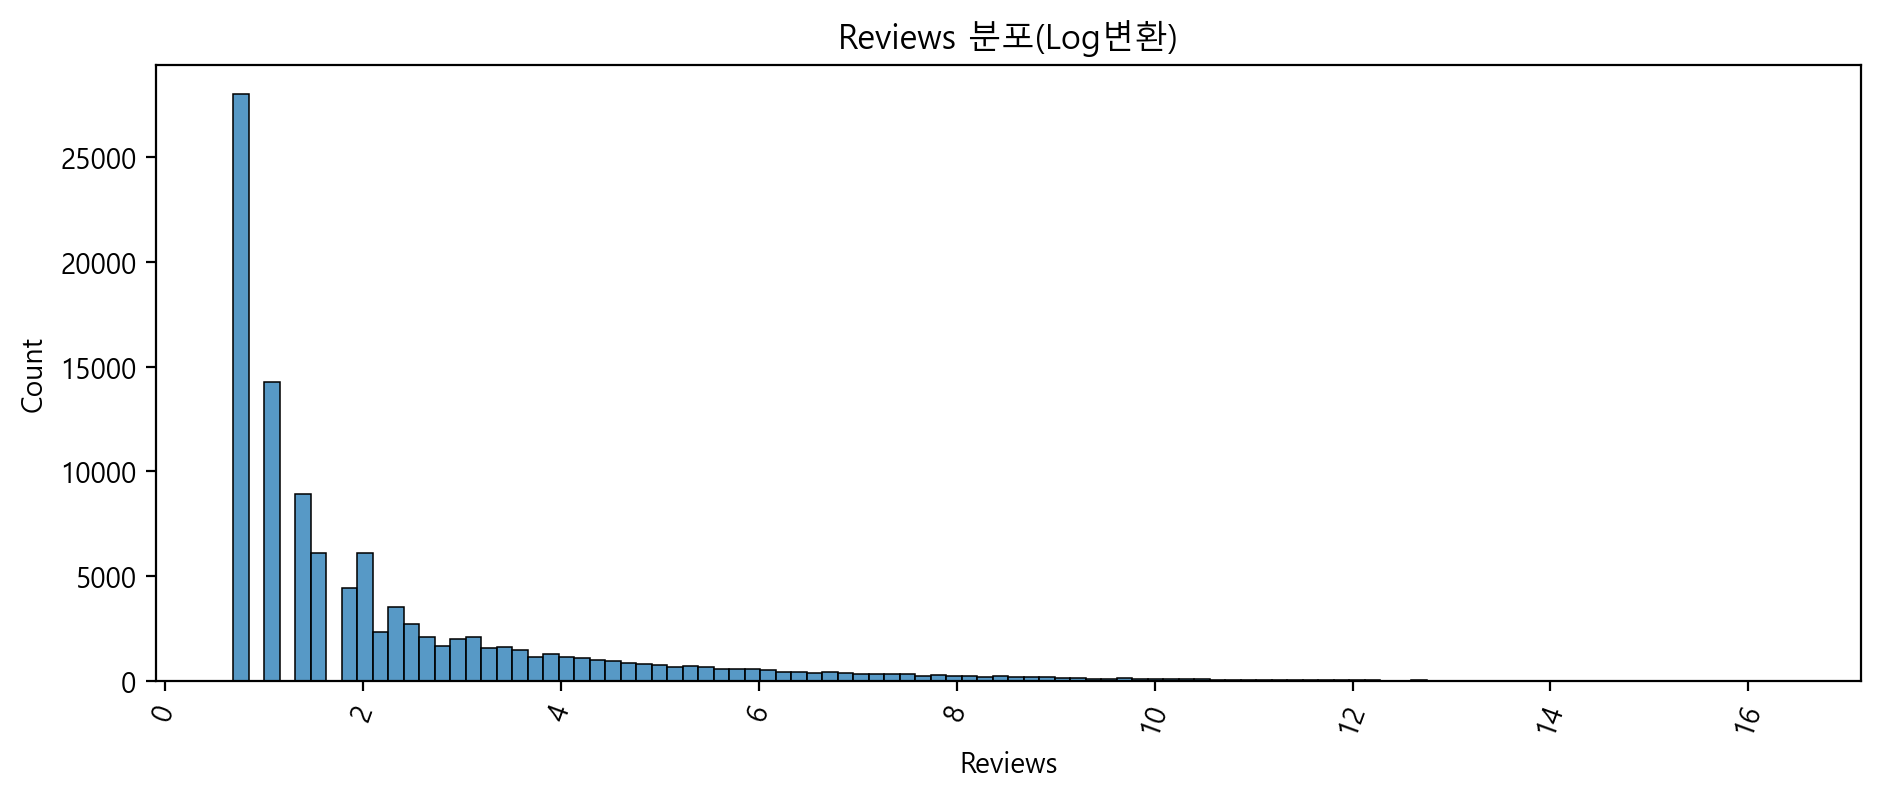

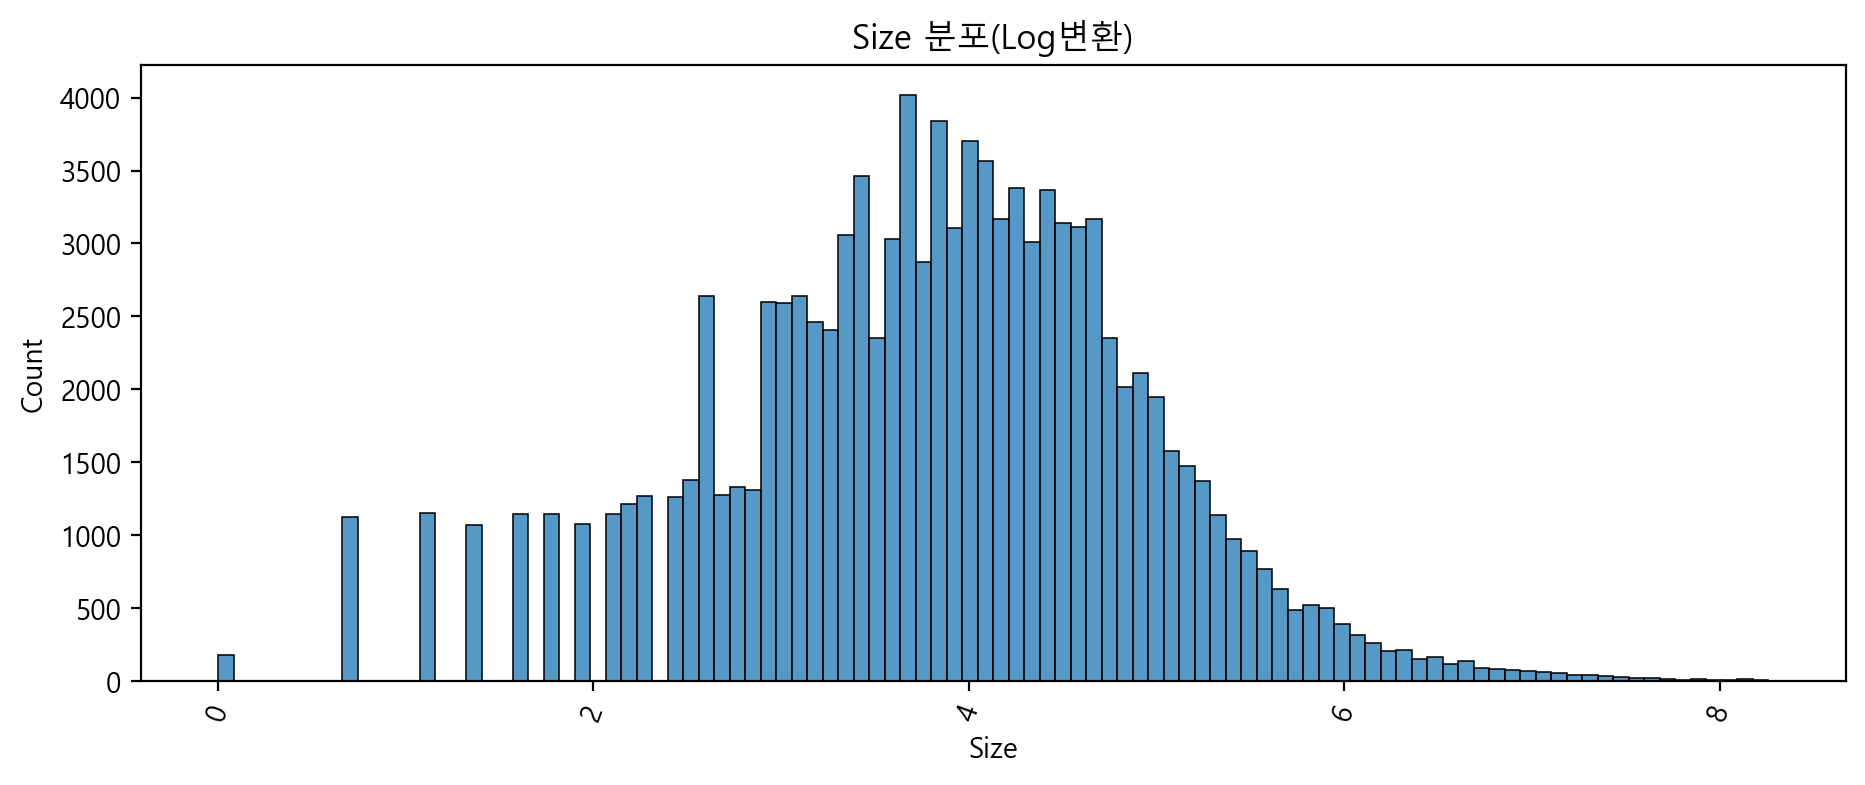

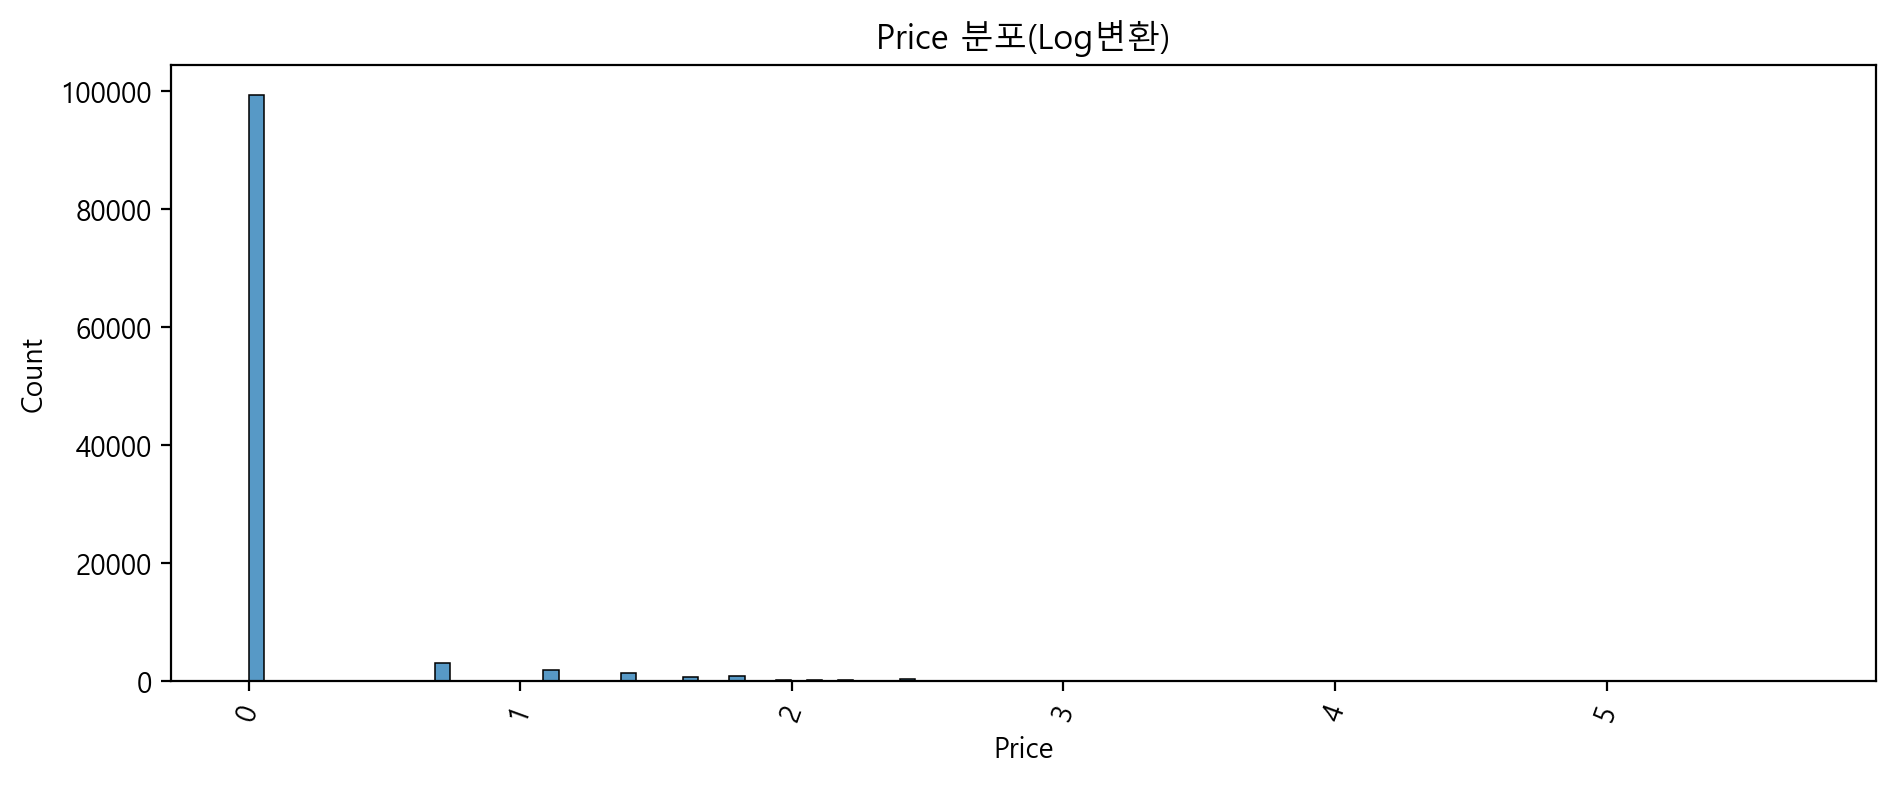

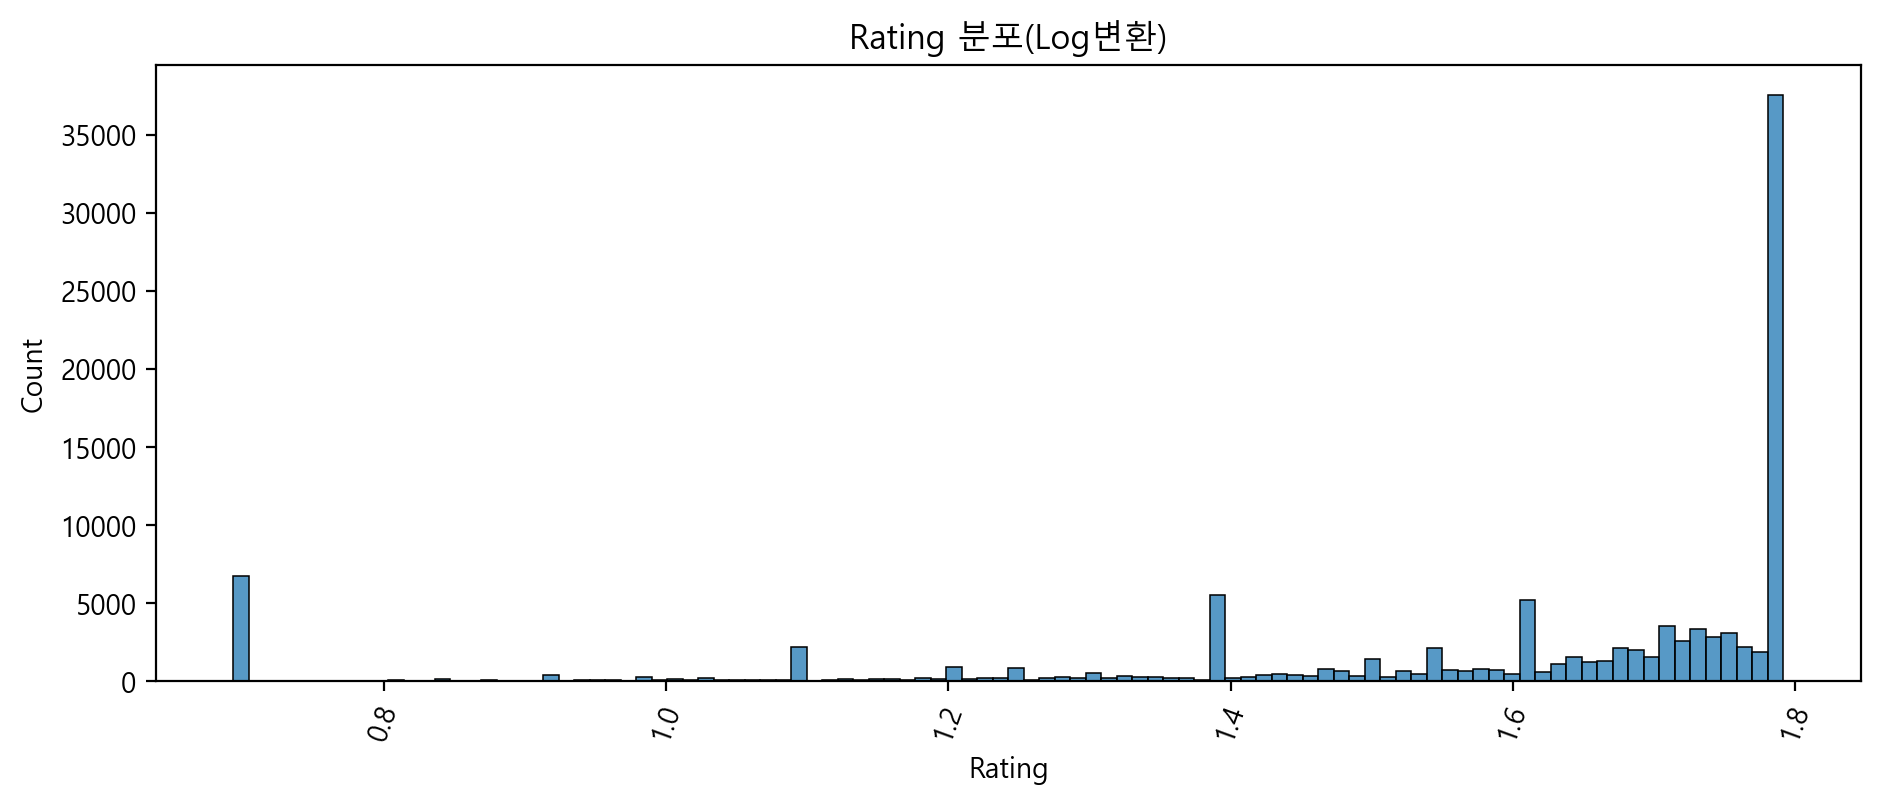

In [101]:
cols =['Category','Available_Age', 'Reviews','Size', 'Price', 'Rating']
cols_skewed = ['Size', 'Price', 'Reviews','Rating']

# data 사이즈가 너무 커서 샘플추출
sampled_data_cat = data_cat.sample(frac=0.2)
# 구간 설정
n_bins = 100 

for col in cols:
    plt.figure(figsize=(11, 4))
    if col in cols_skewed:
        data_to_plot = np.log1p(sampled_data_cat[col])
        plt.title(f'{col} 분포(Log변환)')
        plt.xticks(rotation=70)
        sns.histplot(data_to_plot, bins=n_bins)
    elif col == 'Available_Age':
        data_to_plot = np.log1p(sampled_data_cat[col])
        plt.title(f'{col} 분포(Log변환)')
        plt.xticks(rotation=70)
        sns.histplot(data_to_plot, bins=6)
    else:
        data_to_plot = sampled_data_cat[col]
        plt.title(f'{col} 분포')
        plt.xticks(rotation=70)
        sns.histplot(data_to_plot, bins=n_bins)
    
    plt.show()

---
## Feature 조정
- #### Outlier 제거
- #### log 변환

### 1. Outlier 제거 후 모델링

In [102]:
# skewed된 데이터들의 이상치 제거.
def remove_outlier(data_dum, column):
    df = data_dum[column]
    quan_25 = np.percentile(df.values, 25)
    quan_75 = np.percentile(df.values, 75)
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    data_dum.drop(outlier_index, axis = 0, inplace = True)
    
    return data_dum

In [103]:
for col in cols_skewed:
    data_dum = remove_outlier(data_dum, col)

len(data_dum)

outlier의 수 :  41284
outlier의 수 :  43882
outlier의 수 :  77638
outlier의 수 :  0


383252

In [104]:
data_dum.reset_index(drop=True, inplace=True)

In [105]:
data_dum

,Unnamed: 0,Available_Age,Size,Price,Free,Rating,Reviews,Category_Book,Category_Business,Category_Developer Tools,...,Category_Photo & Video,Category_Productivity,Category_Reference,Category_Shopping,Category_Social Networking,Category_Sports,Category_Stickers,Category_Travel,Category_Utilities,Category_Weather
0,1,1,13,0,True,5.00,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,17,4,46,0,True,4.07,15,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,18,1,58,0,True,3.00,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,20,1,45,0,True,5.00,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,21,1,13,0,True,5.00,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383247,1230351,1,10,0,True,2.60,5,False,False,False,...,False,False,False,False,False,False,False,False,True,False
383248,1230358,1,22,0,True,5.00,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
383249,1230360,1,39,0,True,5.00,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
383250,1230368,1,92,0,True,4.43,7,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [106]:
data_dum['Free'] = data_dum['Free'].apply(lambda x: 0 if x else 1)

In [107]:
# feature, target 설정
X = data_dum.drop(['Unnamed: 0', 'Rating'], axis=1) # feature 다섯개
y = data_dum['Rating']

In [108]:
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()
scaler_rob = RobustScaler()

In [109]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [110]:
# train 데이터 스케일링
# X_train_std_scaled = scaler_std.fit_transform(X_train)
# X_train_mm_scaled = scaler_mm.fit_transform(X_train)
X_train = scaler_rob.fit_transform(X_train)

In [111]:
# test 데이터 스케일링
# X_test_std_scaled = scaler_std.transform(X_test)
# X_test_mm_scaled = scaler_mm.transform(X_test)
X_test = scaler_rob.transform(X_test)

### 스케일러 결정

In [112]:
X1 = data_dum.drop(['Unnamed: 0', 'Rating','Category_Book',
       'Category_Business', 'Category_Developer Tools', 'Category_Education',
       'Category_Entertainment', 'Category_Finance', 'Category_Food & Drink',
       'Category_Games', 'Category_Graphics & Design',
       'Category_Health & Fitness', 'Category_Lifestyle',
       'Category_Magazines & Newspapers', 'Category_Medical', 'Category_Music',
       'Category_Navigation', 'Category_News', 'Category_Photo & Video',
       'Category_Productivity', 'Category_Reference', 'Category_Shopping',
       'Category_Social Networking', 'Category_Sports', 'Category_Stickers',
       'Category_Travel', 'Category_Utilities', 'Category_Weather'], axis=1) # feature 다섯개
y1 = data_dum['Rating']

In [113]:
graph_std_scaler = StandardScaler().fit_transform(X1)
graph_minmax_scaler = MinMaxScaler().fit_transform(X1)
graph_robust_scaler = RobustScaler().fit_transform(X1)

graph_std_scaled_df = pd.DataFrame(graph_std_scaler, columns=X1.columns)
graph_minmax_scaled_df = pd.DataFrame(graph_minmax_scaler, columns=X1.columns)
graph_robust_scaled_df = pd.DataFrame(graph_robust_scaler, columns=X1.columns)

In [144]:
graph_std_scaled_df = graph_std_scaled_df.drop([191502, 187815]) # 187815 191502

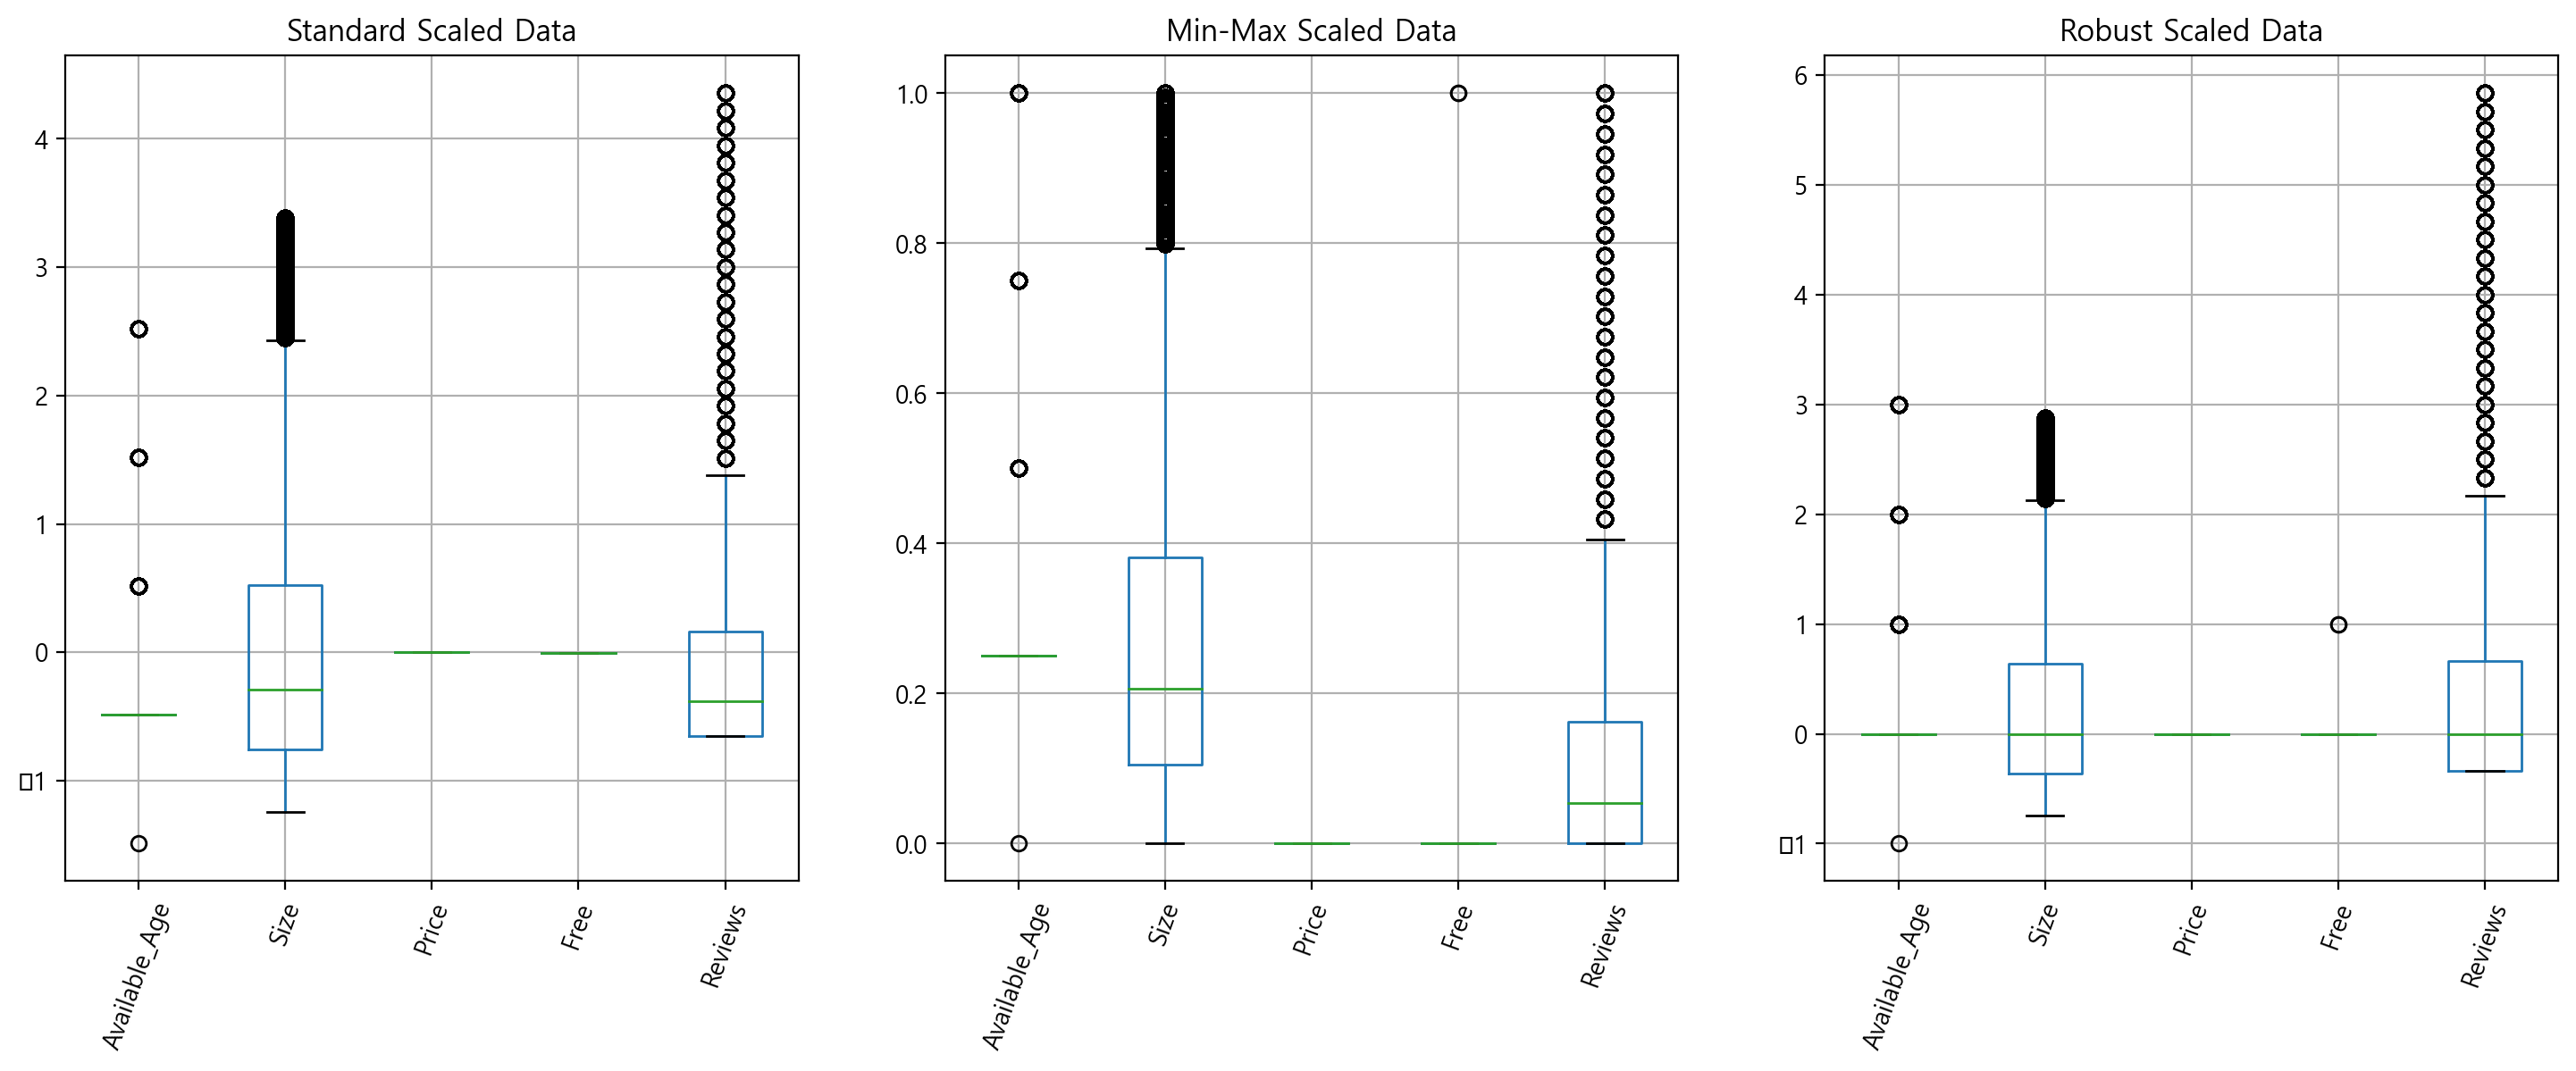

In [145]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Standard Scaled Data')
graph_std_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.subplot(1, 3, 2)
plt.title('Min-Max Scaled Data')
graph_minmax_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.subplot(1, 3, 3)
plt.title('Robust Scaled Data')
graph_robust_scaled_df.boxplot()
plt.xticks(rotation=70)


plt.show()

### 모델준비

In [115]:
# 모델 준비
LR_model = LinearRegression()
RFR_model = RandomForestRegressor()
DTR_model = DecisionTreeRegressor()
GBR_model = GradientBoostingRegressor()
XGB_model = XGBRegressor()
LGBM_model = LGBMRegressor()

In [116]:
# fitting
LR_model.fit(X_train, y_train)

LinearRegression()

In [117]:
RFR_model.fit(X_train, y_train)

RandomForestRegressor()

In [118]:
DTR_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [119]:
GBR_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [120]:
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [121]:
LGBM_model.fit(X_train, y_train)

LGBMRegressor()

In [122]:
# 예측
y_pred_lr = LR_model.predict(X_test)
y_pred_rfr = RFR_model.predict(X_test)
y_pred_dtr = DTR_model.predict(X_test)
y_pred_gbr = GBR_model.predict(X_test)
y_pred_xgb = XGB_model.predict(X_test)
y_pred_lgbm = LGBM_model.predict(X_test)

In [123]:
# MAE, MSE, RMSE
# Linear Regressor
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
# RandomForest Regressor
rmse_rfr = mean_squared_error(y_test, y_pred_rfr, squared=False)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
# DecisionTreeRegressor
rmse_dtr = mean_squared_error(y_test, y_pred_dtr, squared=False)
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
mse_dtr = mean_squared_error(y_test, y_pred_dtr)
# Gradient Boosting Regressor
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
# XGBoosting Regressor
rmse_xgb = mean_squared_error(y_test,y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# LigthGBM Regressor
rmse_lgbm = mean_squared_error(y_test,y_pred_lgbm, squared=False)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)

In [124]:
metrics = {
    'Linear Reg': {'MAE': mae_lr, 'MSE':mse_lr,'RMSE':rmse_lr},
    'Random Forest Reg': {'MAE': mae_rfr, 'MSE':mse_rfr,'RMSE': rmse_rfr},
    'Decision Tree Reg': {'MAE': mae_dtr, 'MSE':mse_dtr,'RMSE': rmse_dtr},
    'Gradient Boosting Reg': {'MAE': mae_gbr, 'MSE':mse_gbr,'RMSE': rmse_gbr},
    'XGBoost Reg': {'MAE': mae_xgb, 'MSE':mse_xgb,'RMSE': rmse_xgb},
    'LightGBM Reg': {'MAE': mae_lgbm, 'MSE':mse_lgbm,'RMSE': rmse_lgbm}
}
result = pd.DataFrame(metrics).round(3).T
result

,MAE,MSE,RMSE
Linear Reg,1.009,1.535,1.239
Random Forest Reg,1.024,1.689,1.300
Decision Tree Reg,1.065,1.878,1.370
Gradient Boosting Reg,0.999,1.514,1.231
XGBoost Reg,0.987,1.505,1.227
LightGBM Reg,0.990,1.502,1.226


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


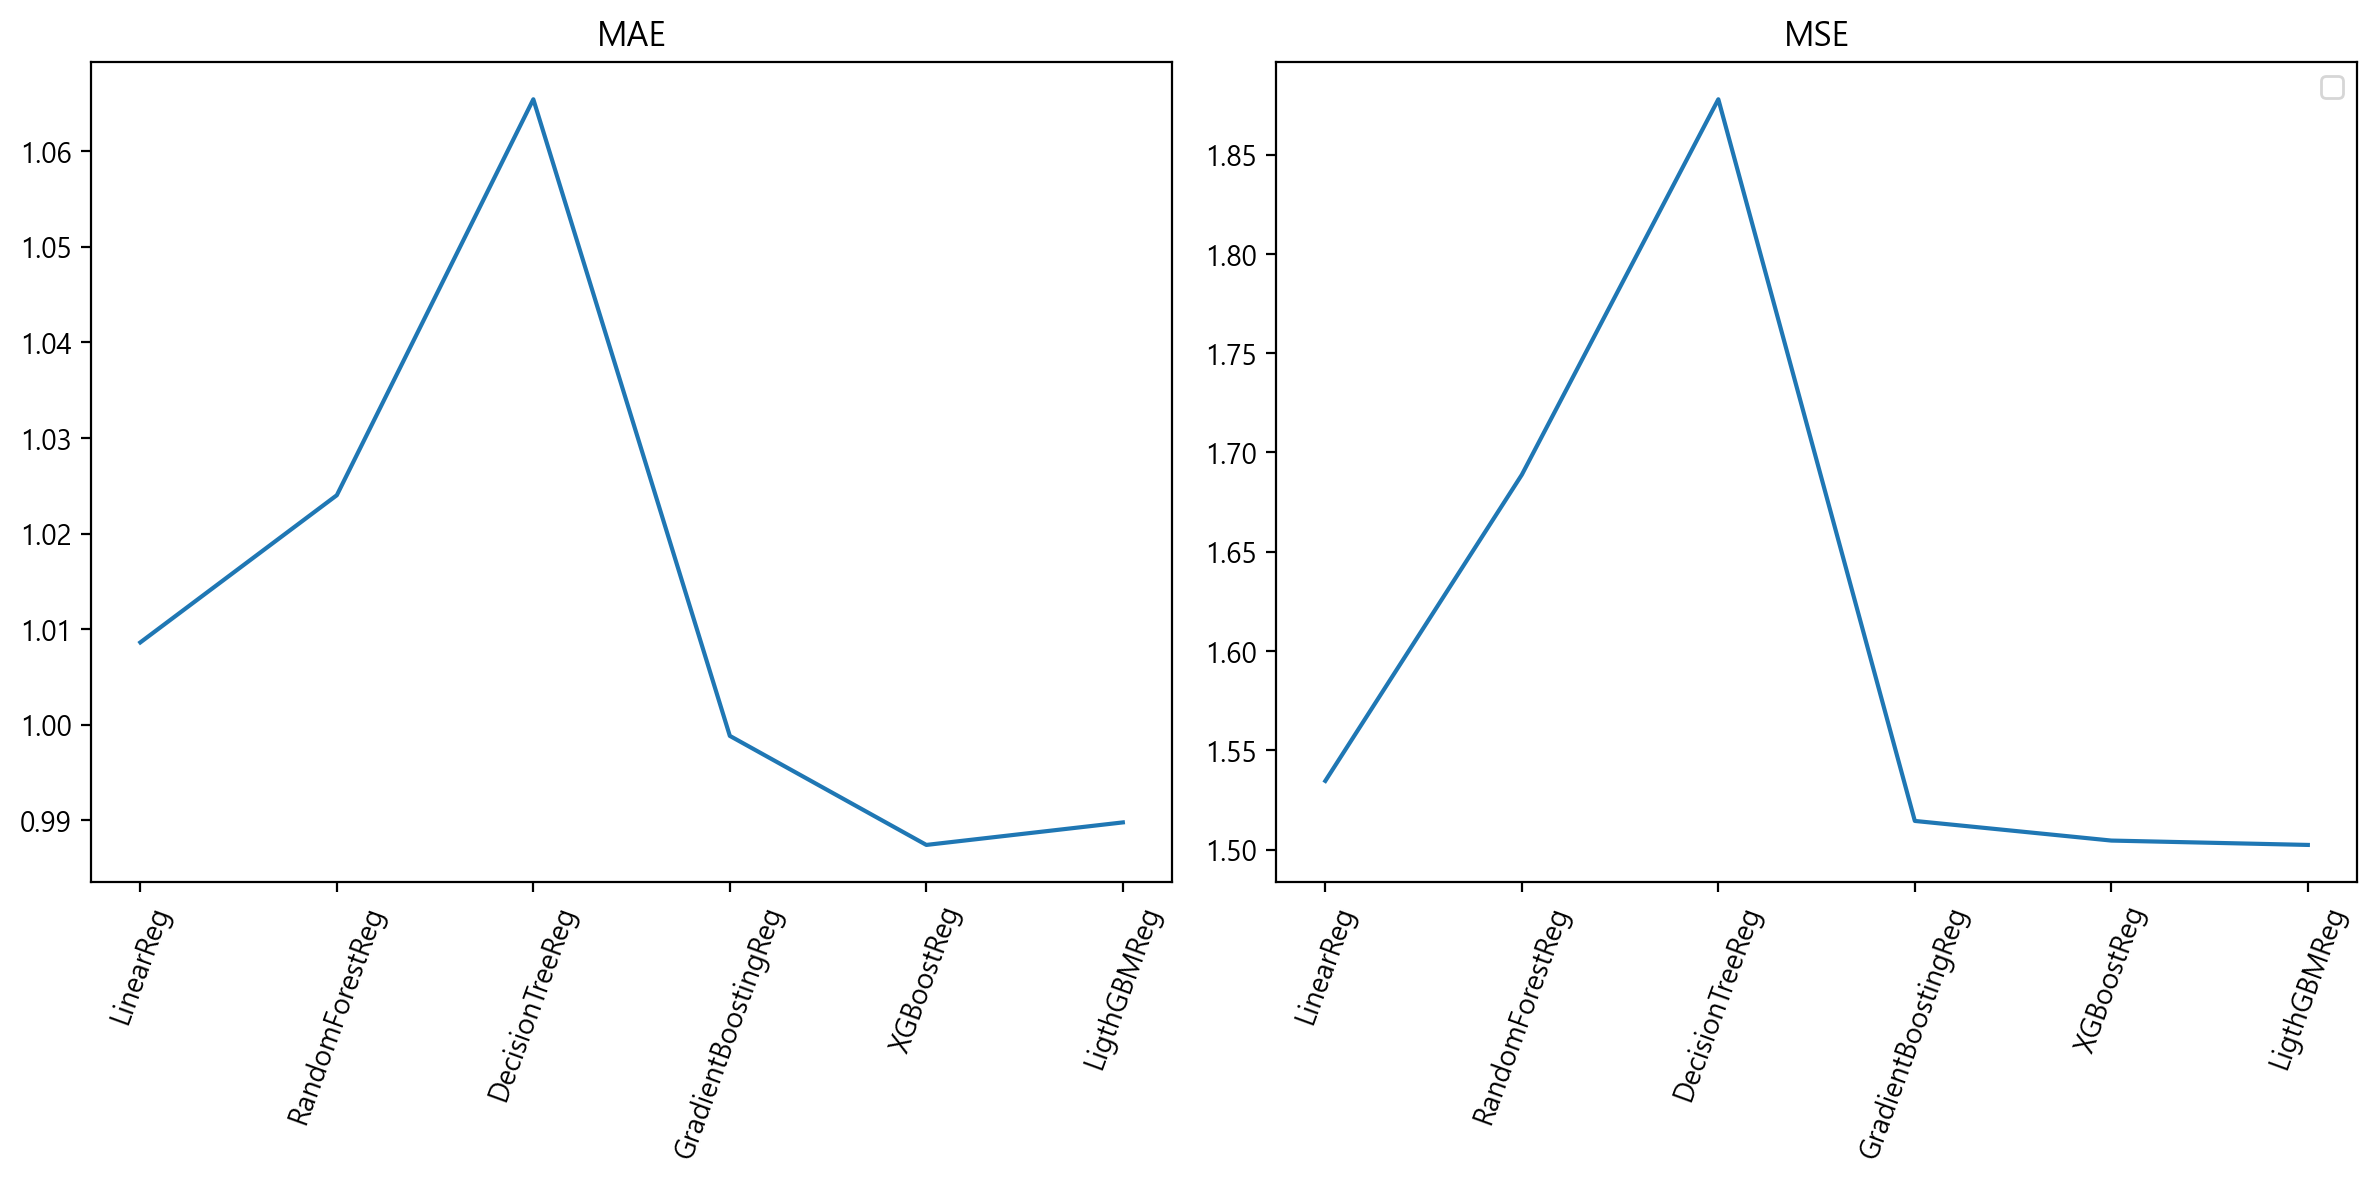

In [125]:
model = ['LinearReg','RandomForestReg','DecisionTreeReg', 'GradientBoostingReg', 'XGBoostReg', 'LigthGBMReg']
mae = [mae_lr,mae_rfr,mae_dtr,mae_gbr, mae_xgb, mae_lgbm]
rmse = [rmse_lr,rmse_rfr,rmse_dtr,rmse_gbr, rmse_xgb, rmse_lgbm]
mse = [mse_lr,mse_rfr,mse_dtr,mse_gbr, mse_xgb, mse_lgbm]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(model,mae)
plt.title('MAE')
plt.xticks(rotation=70)

plt.subplot(1,2,2)
plt.plot(model, mse)
plt.title('MSE')
plt.xticks(rotation=70)
plt.tight_layout()
plt.legend()
plt.show()

In [126]:
# 교차 검증 
kf = KFold(n_splits=5,shuffle=True,random_state=42)
# rmse_total = 0
mse_total=0
mae_total=0

for train, valid in kf.split(X):
    X_train, X_valid = X.iloc[train], X.iloc[valid]
    y_train, y_valid = y.iloc[train], y.iloc[valid]

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    model = XGBRegressor()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)

    # rmse = mean_squared_error(y_vaild, y_pred, squared=False)
    mae = mean_absolute_error(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)

    # rmse_total += rmse
    mse_total += mse
    mae_total += mae

    # print(f'RMSE : {rmse:.3f} / ', end='')
    print(f'MAE : {mae:.3f} / ', end='')
    print(f'MSE : {mse:.3f}')

# print(f'RMSE Avg : {rmse_total/5}')
print(f'MSE Avg : {mse_total/5:.3f}')
print(f'MAE Avg : {mae_total/5:.3f}')

MAE : 0.987 / MSE : 1.505
MAE : 0.986 / MSE : 1.496
MAE : 0.995 / MSE : 1.533
MAE : 0.988 / MSE : 1.509
MAE : 0.990 / MSE : 1.517
MSE Avg : 1.512
MAE Avg : 0.989


In [146]:
# 또 다른 방법
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# mse_scores = -cross_val_score(XGB_model, X, y, cv=5, scoring=mse_scorer)
# mae_scores = -cross_val_score(XGB_model, X, y, cv=5, scoring=mae_scorer)

# print(mse_scores)
# print(mae_scores)

In [128]:
param_range = {
    'n_estimators': randint(100, 500),  # Random integers between 100 and 500
    'max_depth': randint(3, 10),        # Random integers between 3 and 10
    'learning_rate': uniform(0.01, 0.5) # Random numbers between 0.01 and 0.51 (0.01 + 0.5)
}

In [129]:
model = XGBRegressor()

# Initialize RandomizedSearchCV
randomsearch = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_range, 
    n_iter=10,  # Number of parameter settings that are sampled, adjust as needed
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    verbose=2,
    random_state=42  # For reproducibility
)

# Fit RandomizedSearchCV to the training data
randomsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB15F33310>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CB132F13A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CB0ED7A550>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [130]:
print(f'Best Parameters : {randomsearch.best_params_}')
print(f'Best Score : {randomsearch.best_score_}')

Best Parameters : {'learning_rate': 0.08800932022121825, 'max_depth': 5, 'n_estimators': 314}
Best Score : -0.998036552462257


In [131]:
XGB_tuned = XGBRegressor(learning_rate=0.08800932022121825, max_depth=5, n_estimators=314)
XGB_tuned.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08800932022121825,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=314, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [132]:
y_pred_tuned = XGB_tuned.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
# rmse_tuned = mean_squared_error(y_test, y_pred_tuned)

print(f'MSE_Tuned : {mse_tuned}')
print(f'MAE_Tuned : {mae_tuned}')
# print(f'RMSE_Tuned : {rmse_tuned}')

MSE_Tuned : 1.6566128080357196
MAE_Tuned : 1.0064267734627073


In [133]:
result = {
    'XGB_before': {'MSE': mse_gbr, 'MAE': mae_gbr},
    'XGB_tuned': {'MSE': mse_tuned,'MAE': mae_tuned}  #'RMSE' : rmse_xgb 'RMSE' : rmse_tun
}
res = pd.DataFrame(result).round(3)
res

,XGB_before,XGB_tuned
MSE,1.514,1.657
MAE,0.999,1.006


In [134]:
XGB_tuned.feature_importances_


array([0.01526972, 0.01324295, 0.        , 0.00074466, 0.00858348,
       0.00699865, 0.02870936, 0.00597671, 0.02519291, 0.02081559,
       0.01062007, 0.07990061, 0.11112373, 0.00559379, 0.02887355,
       0.05262948, 0.00302617, 0.00534304, 0.03233701, 0.05400856,
       0.00527679, 0.14904286, 0.00565457, 0.00781859, 0.14716169,
       0.01685313, 0.00691034, 0.02193877, 0.01628936, 0.10220084,
       0.01186302], dtype=float32)

In [135]:
col_list = data_dum.columns
type(col_list)

pandas.core.indexes.base.Index

In [136]:
col_list = col_list.drop(['Rating', 'Unnamed: 0'])

In [137]:
important_fea = pd.Series(XGB_tuned.feature_importances_, index=col_list)

# 내림차순 정렬을 이용한다
top15 = important_fea.sort_values(ascending=False)[:20]
print(top15)

Category_Photo & Video        0.149043
Category_Shopping             0.147162
Category_Games                0.111124
Category_Utilities            0.102201
Category_Food & Drink         0.079901
Category_Navigation           0.054009
Category_Lifestyle            0.052629
Category_Music                0.032337
Category_Health & Fitness     0.028874
Category_Business             0.028709
Category_Education            0.025193
Category_Stickers             0.021939
Category_Entertainment        0.020816
Category_Social Networking    0.016853
Category_Travel               0.016289
Available_Age                 0.015270
Size                          0.013243
Category_Weather              0.011863
Category_Finance              0.010620
Reviews                       0.008583
dtype: float32
